# QuTiP lecture: Vacuum Rabi oscillations in the Jaynes-Cummings model

Author: J. R. Johansson (robert@riken.jp), http://dml.riken.jp/~rob/

The latest version of this [IPython notebook](http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html) lecture is available at [http://github.com/jrjohansson/qutip-lectures](http://github.com/jrjohansson/qutip-lectures).

The other notebooks in this lecture series are indexed at [http://jrjohansson.github.com](http://jrjohansson.github.com).

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# make qutip available in the rest of the notebook
from qutip import *

# Introduction

The Jaynes-Cumming model is the simplest possible model of quantum mechanical light-matter interaction, describing a single two-level atom interacting with a single electromagnetic cavity mode. The Hamiltonian for this system is (in dipole interaction form)

### $H = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger + a)(\sigma_- + \sigma_+)$

or with the rotating-wave approximation

### $H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$

where $\omega_c$ and $\omega_a$ are the frequencies of the cavity and atom, respectively, and $g$ is the interaction strength.

### Problem parameters


Here we use units where $\hbar = 1$: 

In [33]:
wc = 0.  # cavity frequency
wa = 0.  # atom frequency
g  = 1.#4.  # coupling strength
kap_1 = 0.1       # cavity dissipation rate
kap_2 = 0.0
gamma = 0.        # atom dissipation rate
N = 5              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation
use_rwa = True
Omc=0.#2#*np.exp(-1j*np.pi*2)/np.sqrt(0.2*0.005)
Ome =0.001# 1.
tlist = np.linspace(0,20,1001)

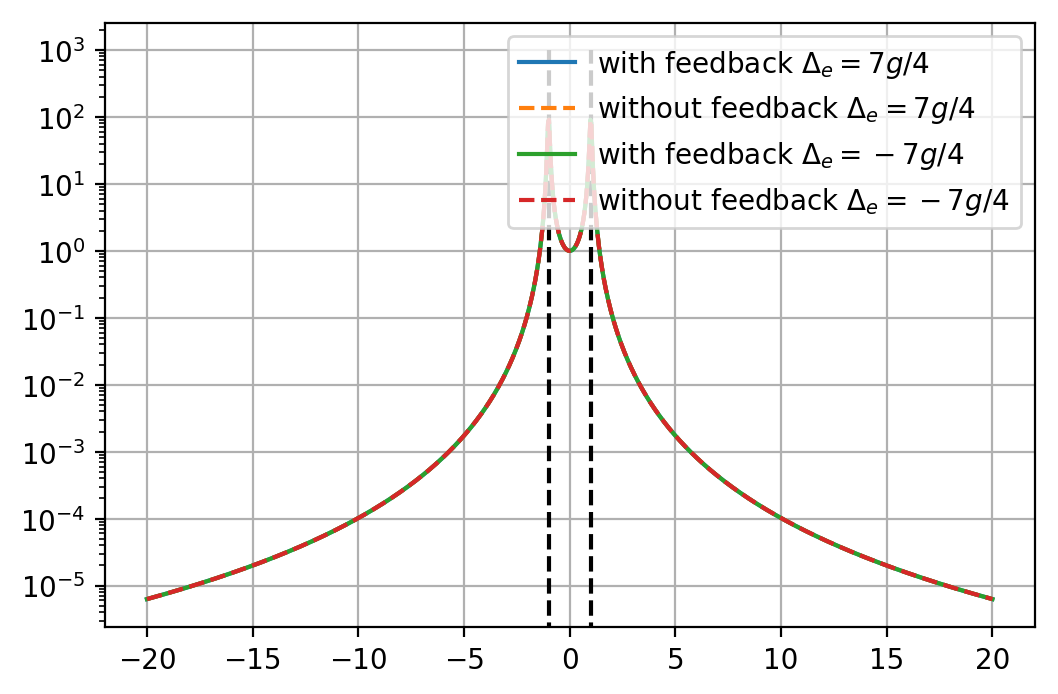

In [34]:
om=np.linspace(-20,20,1000)
k = 2*np.sqrt(kap_1*kap_2)
phi=0
tau = .4
sefb = g**2/((g**2-(om-wa)*(om-wc-k*np.sin(phi+om*tau)))**2+(kap_1+kap_2+k*np.cos(phi+om*tau))**2*(om-wa)**2)
se = g**2/((g**2-(om-wa)*(om-wc))**2+(kap_1+kap_2)**2*(om-wa)**2)
sefb2 = g**2/((g**2-(om+wa)*(om-wc-k*np.sin(phi+om*tau)))**2+(kap_1+kap_2+k*np.cos(phi+om*tau))**2*(om+wa)**2)
se2 = g**2/((g**2-(om+wa)*(om-wc))**2+(kap_1+kap_2)**2*(om+wa)**2)
plt.figure(dpi=200)
plt.plot(om, sefb,ls="-",label="with feedback $\Delta_e=7g/4$")#/np.max(se))
plt.plot(om, se,ls="--",label="without feedback $\Delta_e=7g/4$")#/np.max(se))
plt.plot(om, sefb2,ls="-",label="with feedback $\Delta_e=-7g/4$")#/np.max(se))
plt.plot(om, se2,ls="--",label="without feedback $\Delta_e=-7g/4$")#/np.max(se))

plt.vlines(.5*(wa-np.sqrt(wa**2+4*g**2)),0,1000,linestyle="dashed")
plt.vlines(.5*(wa+np.sqrt(wa**2+4*g**2)),0,1000,linestyle="dashed")
plt.legend(loc="best")
plt.yscale("log")
plt.grid(True)

### Setup the operators, the Hamiltonian and initial state

In [35]:
# intial state
psi0 = tensor(basis(N,0), basis(2,0))    # start with an excited atom
#psi0 = tensor(coherent(N,np.sqrt(6)), basis(2,0))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

# Hamiltonian
if use_rwa:
    H = (wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag()) + Omc*a.dag()+np.conjugate(Omc)*a+
         Ome*sm.dag()+np.conjugate(Ome)*sm)
else:
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
print(a)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.41421356
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.73205081 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.73205081 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         2.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         2.        ]
 [0.         0.         0.         0.

### Create a list of collapse operators that describe the dissipation

In [36]:
c_ops = []

# cavity relaxation
rate = kap_1 * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kap_1 * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# cavity relaxation
rate = kap_2 * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kap_2 * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# qubit relaxation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)
    

In [37]:
a_in_1  = 1j*Omc/np.sqrt(kap_1)*tensor(qeye(N),qeye(2))
a_out_1 = a_in_1 + np.sqrt(kap_1)*a #input only from mirror 1
a_out_2 = np.sqrt(kap_1)*a

### Evolve the system

Here we evolve the system with the Lindblad master equation solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_+\sigma_-$ are returned by the solver by passing the list `[a.dag()*a, sm.dag()*sm]` as the fifth argument to the solver.

In [38]:
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm,a,sm,a.dag()*a.dag()*a*a,
                                         a_out_1.dag()*a_out_1.dag()*a_out_1*a_out_1,a_out_1.dag()*a_out_1,
                                         a_out_2.dag()*a_out_2.dag()*a_out_2*a_out_2,a_out_2.dag()*a_out_2])

## Visualize the results

Here we plot the excitation probabilities of the cavity and the atom (these expectation values were calculated by the `mesolve` above). We can clearly see how energy is being coherently transferred back and forth between the cavity and the atom.

5.297679085087918e-07 -0.9999992813267347 5.297679085087917e-08 5.297679085087917e-08
(1001, 7)


/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'g2')

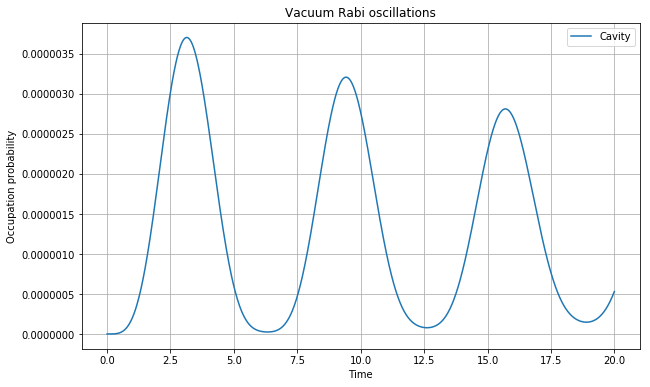

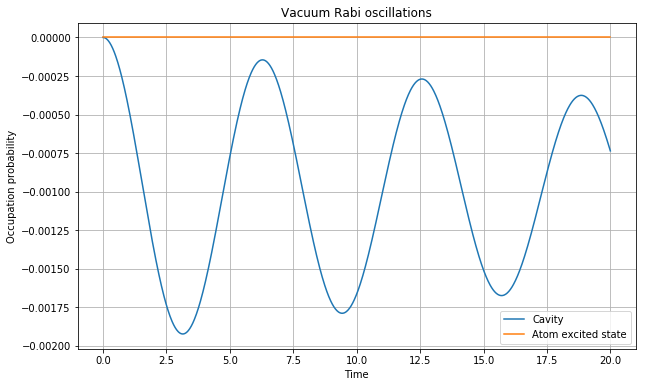

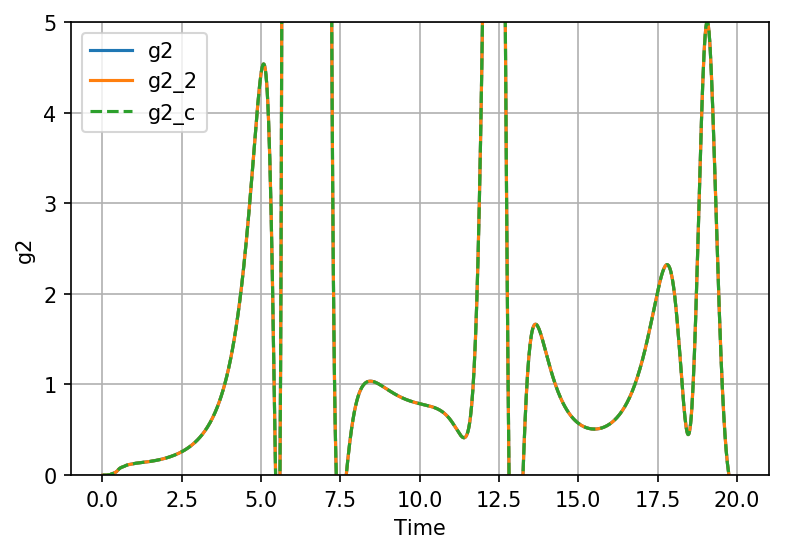

In [40]:
n_c = output.expect[0]
n_a = (output.expect[1]-.5)*2
coh_c = output.expect[2]
coh_a = output.expect[3]
g2_c =  output.expect[4]/n_c**2
n_c1out = output.expect[6]
n_c2out = output.expect[8]
g2 = output.expect[5]/(n_c1out**2)
g2_2 =  output.expect[7]/(n_c2out**2)
print(n_c[-1],n_a[-1],n_c1out[-1],n_c2out[-1])
fig, axes = plt.subplots(1, 1, figsize=(10,6))

ID=600
tau=0.5
axes.plot(tlist, n_c, label="Cavity")
#axes.plot(tlist, n_a, label="Atom excited state")
#axes.plot(tlist, n_c1out,ls="--",label="nc_1out" )
#axes.plot(tlist, n_c2out,ls="--",label="nc_2out" )
out = np.transpose(np.vstack((tlist, n_c, n_a, n_c1out,n_c2out,g2,g2_2)))
print(out.shape)
np.savetxt("./Data/JC+fb/New/Qutip%04d_cavity_drive.txt" % ID,out)
axes.legend(loc=0)
axes.grid(True)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')
#axes.set_xlim(0,10)
fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, coh_c, label="Cavity")
axes.plot(tlist, coh_a, label="Atom excited state")
axes.legend(loc=0)
axes.grid(True)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')
fig, axes = plt.subplots(1, 1, dpi=150)

axes.plot(tlist[0:], g2[0:] ,label="g2" )
axes.plot(tlist[0:], g2_2[0:] ,label="g2_2" )
axes.plot(tlist[0:], g2_c[0:] ,ls="--",label="g2_c" )
axes.grid(True)
#axes.plot(tlist, n_c2out,label="nc_2out" )
axes.set_xlabel('Time')
axes.set_ylim(0,5)
axes.legend(loc='best')
axes.set_ylabel('g2')



## Cavity wigner function

In addition to the cavity's and atom's excitation probabilities, we may also be interested in for example the wigner function as a function of time. The Wigner function can give some valuable insight in the nature of the state of the resonators. 

To calculate the Wigner function in QuTiP, we first recalculte the evolution without specifying any expectation value operators, which will result in that the solver return a list of density matrices for the system for the given time coordinates.

In [201]:
output = mesolve(H, psi0, tlist, c_ops, [])

Now, `output.states` contains a list of density matrices for the system for the time points specified in the list `tlist`:

In [202]:
output

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 0

In [203]:
type(output.states)

list

In [204]:
len(output.states)

In [199]:
output.states[-1] # indexing the list with -1 results in the last element in the list

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[  9.35842988e-01 -3.78629052e-17j  -1.17883138e-01 -1.04758703e-02j
    2.06286421e-01 +1.84228615e-02j  -2.55750452e-02 -5.36545059e-03j
    4.20291497e-02 +8.51236444e-03j  -5.09313867e-03 -1.75667530e-03j
    7.68886091e-03 +2.63020139e-03j  -8.78913150e-04 -4.46807712e-04j
    1.25640170e-03 +6.38662408e-04j   1.33305690e-04 +4.92182734e-05j]
 [ -1.17883138e-01 +1.04758703e-02j   1.51903287e-02 +2.89896442e-19j
   -2.61935007e-02 -1.24118237e-05j   3.23611013e-03 +4.09336319e-04j
   -5.46409193e-03 -6.02467104e-04j   6.86277933e-04 +1.59911476e-04j
   -9.97975593e-04 -2.54882237e-04j   1.13835678e-04 +5.05265032e-05j
   -1.69665440e-04 -6.67452494e-05j  -1.99553313e-05 -4.42061742e-06j]
 [  2.06286421e-01 -1.84228615e-02j  -2.61935007e-02 +1.24118237e-05j
    4.60571532e-02 +8.88780165e-18j  -5.82144624e-03 -6.82361558e-04j
    9.49812938e-03 +1.06969495e-03j  -1.16472931e-03 -2.9752

Now let's look at the Wigner functions at the point in time when atom is in its ground state: $t = \\{5, 15, 25\\}$ (see the plot above). 

For each of these points in time we need to:

 1. Find the system density matrix for the points in time that we are interested in.
 2. Trace out the atom and obtain the reduced density matrix for the cavity.
 3. Calculate and visualize the Wigner function fo the reduced cavity density matrix.

In [200]:
# find the indices of the density matrices for the times we are interested in
t_idx = np.where([tlist == t for t in [0.0, 1.0, 2.0,3.0, 4.0,5.0,6.0, 7.0,8.0,9.0,10.0]])[1]
print(np.where([tlist == t for t in [0.0, 5.0, 15.0, 25.0]]))
tlist[t_idx]

(array([0, 2]), array([  0, 500]))


array([ 0.,  3.,  6.,  9.])

In [201]:
# get a list density matrices
rho_list = np.array(output.states)[t_idx]
rho_list[1]

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[  9.39064898e-01 -4.70856284e-17j  -9.24496685e-02 +4.35748046e-02j
    1.76278075e-01 -8.60225253e-02j  -1.87320644e-02 +2.83418107e-02j
    1.72569664e-02 -5.52851239e-02j   3.67362583e-03 +1.63787299e-02j
   -1.71702007e-03 -2.21711615e-02j   9.27328145e-04 +4.54020157e-03j
   -2.59258043e-03 -7.73705157e-03j  -3.60159321e-04 -7.87947390e-04j]
 [ -9.24496685e-02 -4.35748046e-02j   1.16789927e-02 -1.31907163e-17j
   -2.19796681e-02 +6.89903764e-04j   3.29603789e-03 -2.12574081e-03j
   -4.68532967e-03 +4.84591692e-03j   5.35274688e-04 -1.79640385e-03j
   -1.02167532e-03 +2.33098018e-03j   1.59492027e-04 -5.02307579e-04j
   -1.82907055e-04 +8.80029633e-04j  -9.71052251e-06 +9.19291531e-05j]
 [  1.76278075e-01 +8.60225253e-02j  -2.19796681e-02 -6.89903764e-04j
    4.25271692e-02 +5.56218291e-17j  -6.67477574e-03 +3.80208268e-03j
    9.15040291e-03 -8.69690366e-03j  -1.01977091e-03 +3.2913

[  9.99924016e-01   7.59848785e-05  -2.97907767e-08   7.49914624e-09
   2.16720965e-08]
[-0.5  0.5  1.5  2.5  3.5]


<BarContainer object of 5 artists>

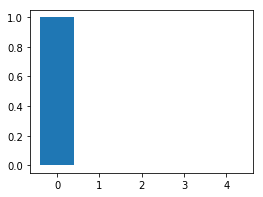

In [205]:
rho = ptrace(output.states[-1], 0)
fig, axes = plt.subplots(1, 1, figsize=(4,3))
dist = rho.diag()
print(rho.diag())
xlist=np.arange(0,rho.shape[-1])-.5
print(xlist)
plt.bar(np.arange(len(dist)),dist)


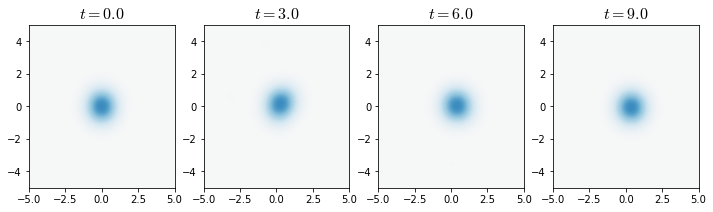

In [203]:
# loop over the list of density matrices

# find the indices of the density matrices for the times we are interested in
t_idx = np.where([tlist == t for t in [0.0, 1.0, 2.0,3.0, 4.0,5.0,6.0, 7.0,8.0,9.0,10.0]])[1]
rho_list = np.array(output.states)[t_idx]
xvec = np.linspace(-5,5,200)

fig, axes = plt.subplots(1,len(rho_list), sharex=True, figsize=(3*len(rho_list),3))

for idx, rho in enumerate(rho_list):

    # trace out the atom from the density matrix, to obtain
    # the reduced density matrix for the cavity
    rho_cavity = ptrace(rho, 0)
    
    # calculate its wigner function
    W = wigner(rho_cavity, xvec, xvec)
    
    # plot its wigner function
    axes[idx].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.5,.5), cmap=plt.get_cmap('RdBu'))

    axes[idx].set_title(r"$t = %.1f$" % tlist[t_idx][idx], fontsize=16)
    

In [701]:
vec=np.random.rand(4)+1j*np.random.rand(4)
print(vec)
vec=vec/np.sqrt(np.dot(vec,np.conjugate(vec)))
print(vec)
Qobj(vec)

[ 0.31355752+0.53366212j  0.28509469+0.25193782j  0.51198421+0.39747164j
  0.94020026+0.30525395j]
[ 0.22598875+0.38462364j  0.20547488+0.18157789j  0.36899983+0.28646776j
  0.67762586+0.22000416j]


Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.22598875+0.38462364j]
 [ 0.20547488+0.18157789j]
 [ 0.36899983+0.28646776j]
 [ 0.67762586+0.22000416j]]

At $t =0$, the cavity is in it's ground state. At $t = 5, 15, 25$ it reaches it's maxium occupation in this Rabi-vacuum oscillation process. We can note that for $t=5$ and $t=15$ the Wigner function has negative values, indicating a truely quantum mechanical state. At $t=25$, however, the wigner function no longer has negative values and can therefore be considered a classical state.

### Alternative view of the same thing

4


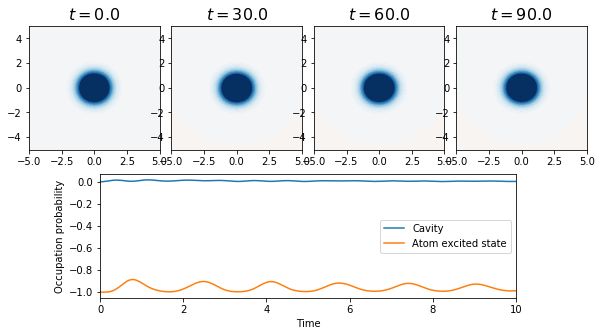

In [702]:
#t_idx = np.where([tlist == t for t in [0.0, 5.0, 10, 15, 20, 25]])[1]
t_idx = np.where([tlist == t for t in [0.0, 10.0, 20., 30., 40., 50.,60.,70.,80.,90.]])[1]
print(len(t_idx))
rho_list = np.array(output.states)[t_idx]

fig_grid = (2, len(rho_list)*2)
fig = plt.figure(figsize=(2.5*len(rho_list),5))

for idx, rho in enumerate(rho_list):
    #print(rho)
    rho_cavity = ptrace(rho, 0)
    #print(rho_cavity)
    W = wigner(rho_cavity, xvec, xvec)
    ax = plt.subplot2grid(fig_grid, (0, 2*idx), colspan=2)
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.1,.1), cmap=plt.get_cmap('RdBu'))
    ax.set_title(r"$t = %.1f$" % tlist[t_idx][idx], fontsize=16)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1]-2))
ax.plot(tlist, n_c, label="Cavity")
ax.plot(tlist, n_a, label="Atom excited state")
ax.legend()
ax.set_xlim(0,10)
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability');

In [103]:
wlist = np.linspace(-20,20,10001)
spec3 = spectrum(H, wlist, c_ops, a.dag(), a)
out = np.transpose(np.vstack((wlist, spec3)))
print(out.shape)
np.savetxt("./Data/JC+fb/New/Spec_Qutip%04d_cavity_drive.txt" % ID,out)


(10001, 2)


/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


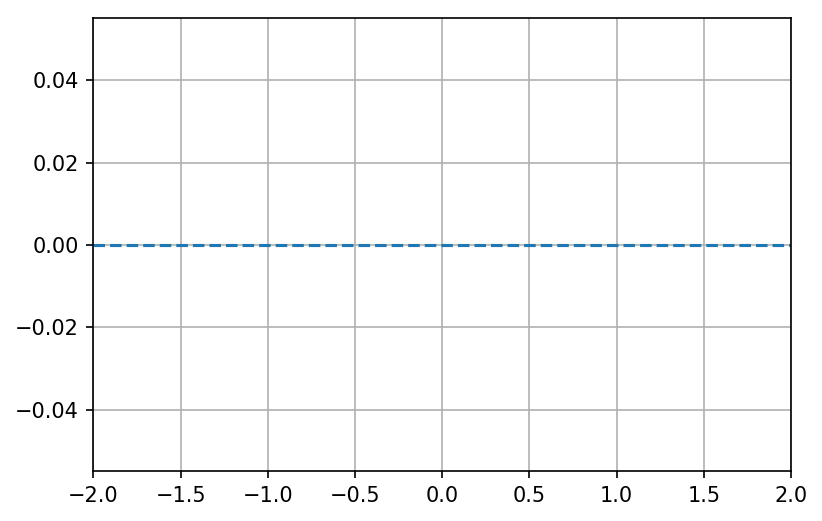

In [104]:
plt.figure(dpi=150)
#plt.plot(wlist,spec)
#plt.plot(wlist,spec2)
plt.plot(wlist,spec3*0.002,ls="--")
Lorentz = 0.2/((wlist-.075)**2+.2**2)
Lorentz = Lorentz/np.max(Lorentz)*np.max(spec3*0.002)
#plt.plot(wlist,Lorentz)
plt.vlines(-.2,np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.vlines(.2,np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
#plt.vlines(-2,np.min(spec2),np.max(spec2),color="grey",linestyle="--")
#plt.vlines(-8.9,np.min(spec3),np.max(spec3),color="grey",linestyle="--")
plt.vlines(.5*(4+np.sqrt(4**2+4*4**2)),np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.vlines(.5*(4+np.sqrt(4**2-4*4**2)),np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.vlines(-.5*(4+np.sqrt(4**2+4*4**2)),np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.vlines(-.5*(4-np.sqrt(4**2+4*4**2)),np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.vlines(-.5*(4+np.sqrt(4**2+8*4**2)),np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.vlines(.5*(4-np.sqrt(4**2+4*4**2)),np.min(spec3*0.002),np.max(spec3*0.002),color="grey",linestyle="--")
plt.xlim(-2,2)
plt.grid(True)
#plt.yscale("log")

1.81507290637


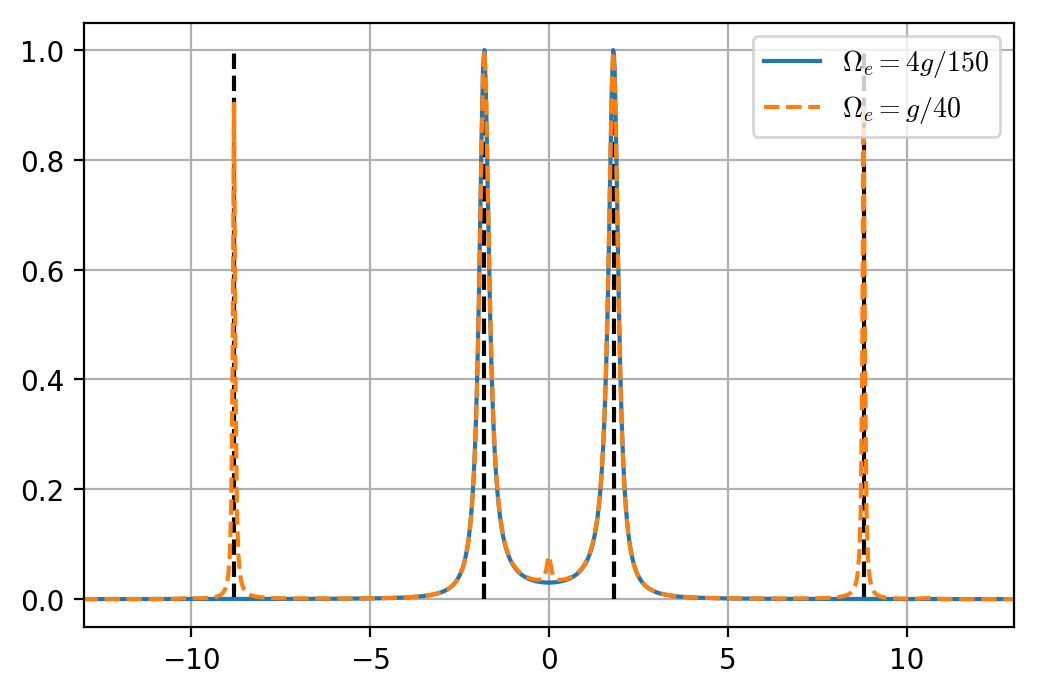

In [415]:
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

s1 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0210_cavity_drive.txt")
#s2 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0300_cavity_drive.txt")
#s3 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0301_cavity_drive.txt")
#s4 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0302_cavity_drive.txt")
#s5 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0303_cavity_drive.txt")
#s6 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0304_cavity_drive.txt")
#s2 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0305_cavity_drive.txt")
#s3 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0306_cavity_drive.txt")
#s4 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0307_cavity_drive.txt")
#s5 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0308_cavity_drive.txt")
#s2 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0309_cavity_drive.txt")
#s3 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0310_cavity_drive.txt")
#s4 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0311_cavity_drive.txt")
s2 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0312_cavity_drive.txt")
s3 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0313_cavity_drive.txt")
s4 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0314_cavity_drive.txt")
s5 = np.loadtxt("./Data/JC+fb/New/Spec_Qutip0315_cavity_drive.txt")

plt.figure(dpi=200)
#plt.plot(s1[:,0],s1[:,1],label="$\gamma=0$")
#plt.plot(s2[:,0],s2[:,1],label="$\gamma=g/40$")
#plt.plot(s3[:,0],s3[:,1],label="$\gamma=g/8$")
#plt.plot(s4[:,0],s4[:,1],label="$\gamma=g/4$")
#plt.plot(s5[:,0],s5[:,1],label="$\gamma=g$")
#plt.plot(s6[:,0],s6[:,1],label="$\gamma=2.5g$")
#plt.plot(s1[:,0],s1[:,1],label="$\Delta_e=7g/4$")
#plt.plot(s2[:,0],s2[:,1],label="$\Delta_e=5g/4$")
#plt.plot(s3[:,0],s3[:,1],label="$\Delta_e=g$")
#plt.plot(s4[:,0],s4[:,1],label="$\Delta_e=g/2$")
#plt.plot(s5[:,0],s5[:,1],label="$\Delta_e=g/10$")
#plt.plot(s5[:,0],s5[:,1]/np.max(s5[:,1]),label="$\kappa_1=g/10$")
print(.5*np.sqrt(7**2+8**2)-3.5)
plt.vlines(.5*np.sqrt(7**2+8**2)-3.5,0,1,linestyle="--")
plt.vlines(-3.5-.5*np.sqrt(7**2+8**2),0,1,linestyle="--")
plt.vlines(3.5-.5*np.sqrt(7**2+8**2),0,1,linestyle="--")
plt.vlines(3.5+.5*np.sqrt(7**2+8**2),0,1,linestyle="--")
#plt.plot(s2[:,0],s2[:,1]/np.max(s2[:,1]),label="$\kappa_1=g/4$")
#plt.plot(s3[:,0],s3[:,1]/np.max(s3[:,1]),label="$\kappa_1=g$")
#plt.plot(s4[:,0],s4[:,1]/np.max(s4[:,1]),label="$\kappa_1=2.5g$")
plt.plot(s2[:,0],s2[:,1]/np.max(s2[:,1]),label="$\Omega_e=4g/150$")
plt.plot(s1[:,0],s1[:,1]/np.max(s1[:,1]),label="$\Omega_e=g/40$",ls="--")
#plt.plot(s2[:,0],s2[:,1]/np.max(s2[:,1]),label="$\Omega_e=g/20$")
#plt.plot(s4[:,0],s4[:,1]/np.max(s4[:,1]),label="$\Omega_e=g/8$")
#plt.yscale("log")
#plt.plot(s5[:,0],s5[:,1],label="$\Delta_e=g/10$")
plt.xlim(-13,13)
plt.legend(loc="best")
plt.grid(True)

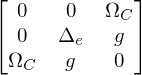

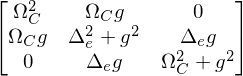

In [414]:
import sympy as sym
from sympy import init_printing
init_printing()

Om_c,Dele,Delc,g, = sym.symbols("\Omega_C \Delta_e Delta_c g",real=True)
Hp = sym.Matrix([[0,0,Om_c,0,0,0,0,0,0,0],
                [0,Dele,g,Om_c,0,0,0,0,0,0],
                [Om_c,g,0,0,sym.sqrt(2)*Om_c,0,0,0,0,0],
                [0,Om_c,0,Dele,sym.sqrt(2)*g,sym.sqrt(2)*Om_c,0,0,0,0],
                [0,0,sym.sqrt(2)*Om_c,sym.sqrt(2)*g,0,0,sym.sqrt(3)*Om_c,0,0,0],
                [0,0,0,sym.sqrt(2)*Om_c,0,Dele,sym.sqrt(3)*g,sym.sqrt(3)*Om_c,0,0],
                [0,0,0,0,sym.sqrt(3)*Om_c,sym.sqrt(3)*g,0,0,2*Om_c,0],
                [0,0,0,0,0,sym.sqrt(3)*Om_c,0,Dele,2*g,2*Om_c],
                [0,0,0,0,0,0,2*Om_c,2*g,0,0],
                [0,0,0,0,0,0,0,2*Om_c,0,Dele]])
H2 = sym.Matrix([[0,0,Om_c,0,0,0],
                [0,Dele,g,Om_c,0,0,],
                [Om_c,g,Delc,0,sym.sqrt(2)*Om_c,0],
                [0,Om_c,0,Delc+Dele,sym.sqrt(2)*g,sym.sqrt(2)*Om_c],
                [0,0,sym.sqrt(2)*Om_c,sym.sqrt(2)*g,0,0],
                [0,0,0,sym.sqrt(2)*Om_c,0,Dele]])
Delc=0
#Om_c=0
H1 = sym.Matrix([[0,0,Om_c],
                [0,Dele,g],
                [Om_c,g,Delc]])
display(H1)
display(H1**2)
vec = H1.eigenvects()
#display(vec)
#display(vec[0].subs(Om_c,0))
#display(vec[1].subs(Om_c,0))
#display(vec[2].subs(Om_c,0))
#display(vec[3].subs(Om_c,0))
#vec2 = H2.eigenvects()

eigenvalue 1:


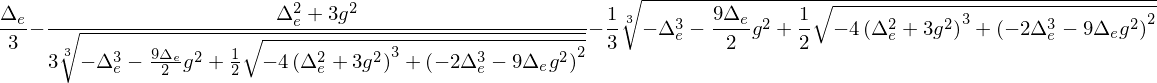

eigenvector 1:


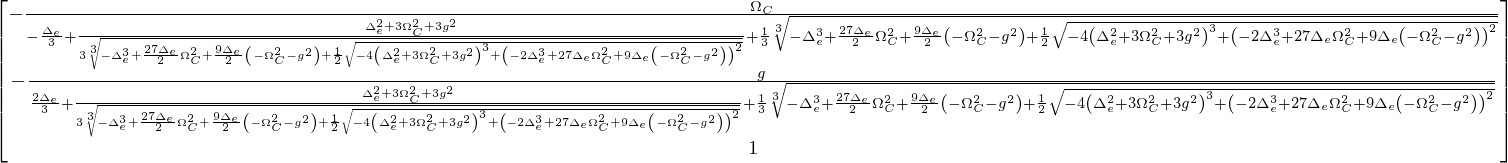

eigenvalue 2:


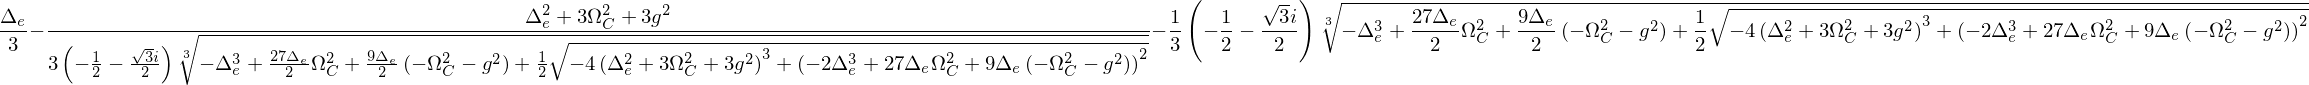

eigenvector 2:


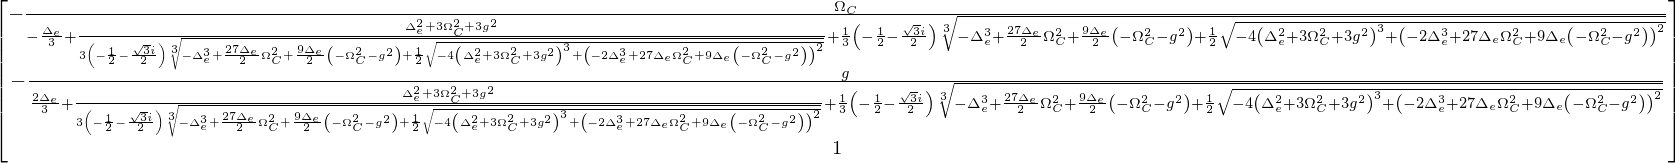

eigenvalue 3:


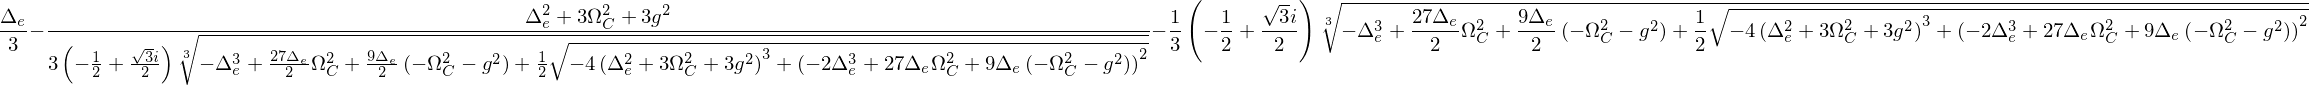

eigenvector 3:


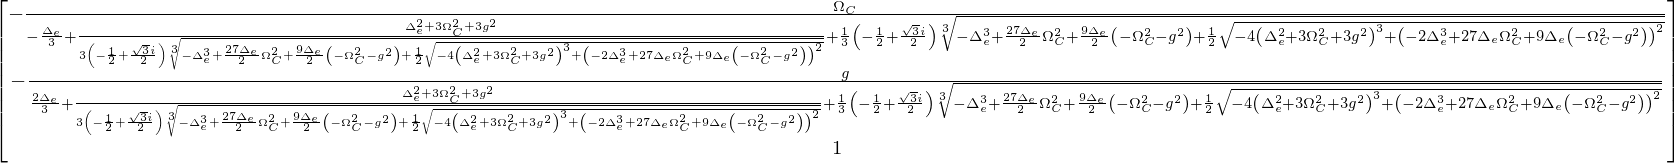

In [413]:
exp = (sym.sqrt(Dele**2+4*Om_c**2+2*g**2-2*sym.sqrt(4*Dele**2*Om_c**2+4*Om_c**2*g**2+g**4)))
exp2 = (sym.sqrt(Dele**2+4*Om_c**2+2*g**2+2*sym.sqrt(4*Dele**2*Om_c**2+4*Om_c**2*g**2+g**4)))
eA2 = Dele**2+3*Om_c**2+3*g**2
eB2 = -Dele**3+27*Dele/2*Om_c**2+9*Dele/2*(-Om_c**2-g**2)
xip,xim,etap,etam,zetap,zetam,A,B= sym.symbols("\\xi_p \\xi_m \eta_p \eta_m \zeta_p \zeta_m A B")
#display(A2)
print("eigenvalue 1:")
display(vec[0][0].subs(Om_c,0))#subs(eA2,A).subs(eB2,Dele*B).subs(2*eB2,2*Dele*B))
print("eigenvector 1:")
display(vec[0][2][0])
print("eigenvalue 2:")
display(vec[1][0])
print("eigenvector 2:")
display(vec[1][2][0])
print("eigenvalue 3:")
display(vec[2][0])
print("eigenvector 3:")
display(vec[2][2][0])
#display(vec[3][0].subs(exp2,xip))
#display(vec[2][2][0].subs(exp2,xip).subs(Dele/2-xip/2,zetam).subs(Dele/2+xip/2,zetap))

### Software versions

In [245]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.3
SciPy,1.1.0
matplotlib,2.2.2
Cython,0.28.3
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,6.3.1
Python,"3.5.5 |Anaconda, Inc.| (default, Mar 12 2018, 23:12:44) [GCC 7.2.0]"
OS,posix [linux]
